# Regularization

As a general term, *regularization* refers to modifying something that is difficult to compute accurately with something more tractable. For learning models, regularization is a common way to combat overfitting.

Imagine we had an $\real^{n\times 4}$ feature matrix in which the features are identical; that is, the predictor variables satisfy $x_1=x_2=x_3=x_4$, and suppose the target $y$ also equals $x_1$. Clearly, we get a perfect regression if we use

$$
y = 1x_1 + 0x_2 + 0x_3 + 0x_4.
$$

But an equally good regression is 

$$
y = \frac{1}{4}x_1 + \frac{1}{4}x_2 + \frac{1}{4}x_3 + \frac{1}{4}x_4.
$$

For that matter, so is

$$
y = 1000x_1 - 500x_2 - 500x_3 + 1x_4.
$$

A problem with more than one solution is called **ill-posed**. If we made tiny changes to the predictor variables in this thought experiment, the problem would technically be well-posed, but there would be a wide range of solutions that were very nearly correct, in which case the problem is said to be **ill conditioned**, and for practical purposes it remains just as difficult.

The ill conditioning can be regularized away by modifying the least squares loss function to penalize complexity in the model, in the form of excessively large regression coefficients. The common choices are **ridge regression**,

$$
L(\bfw) = \twonorm{ \bfX \bfw- \bfy }^2 + \alpha \twonorm{\bfw}^2,
$$

and **LASSO**, 

$$
L(\bfw) = \twonorm{ \bfX \bfw- \bfy }^2 + \alpha \onenorm{\bfw}.
$$

As $\alpha\to 0$, both forms revert to the usual least squares loss, but as $\alpha \to \infty$, the optimization becomes increasingly concerned with prioritizing a small result for $\bfw$. 

While ridge regression is an easier function to minimize quickly, LASSO has an interesting advantage, as illustrated in this figure.

```{figure} ../_static/regularization.png
```

LASSO tends to produce **sparse** results, meaning that some of the regression coefficients are zero or negligible. These zeros indicate predictor variables that have minor predictive value, which can be valuable information in itself. Moreover, when regression is run without these variables, there may be little effect on the bias, but a reduction in variance.

## Case study: Diabetes progression

We'll apply regularized regression to data collected about the progression of diabetes.

In [1]:
from sklearn import datasets
diabetes = datasets.load_diabetes(as_frame=True)["frame"]
diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


First, we look at basic linear regression on all 10 predictive features in the data.

In [2]:
X = diabetes.drop("target",axis=1)
y = diabetes["target"]

from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=2)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_tr,y_tr)
print("linear model CoD score:",lm.score(X_te,y_te))

linear model CoD score: 0.4399387660024645


We will find that ridge regression improves the score a bit, at least for some hyperparameter values:

In [3]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=0.1)  # alpha weights the regularization term
rr.fit(X_tr,y_tr)
print("ridge regression CoD score:",rr.score(X_te,y_te))

ridge regression CoD score: 0.4519973816947853


Ridge regularization added a penalty for the 2-norm of the regression coefficients vector. Accordingly, the regularized solution has smaller coefficients:

In [4]:
from numpy.linalg import norm
print("2-norm of unregularized model coefficients:",norm(lm.coef_))
print("2-norm of ridge regression coefficients:",norm(rr.coef_))

2-norm of unregularized model coefficients: 1525.2110583591316
2-norm of ridge regression coefficients: 808.5402825823023


As we continue to increase the regularization parameter, the method becomes increasingly obsessed with keeping the coefficient vector small, and pays ever less attention to the data as a result. Eventually, the quality of fit will decrease.

In [5]:
rr = Ridge(alpha=4)  # more regularization
rr.fit(X_tr,y_tr)
print("2-norm of coefficient vector:",norm(rr.coef_))
print("ridge regression CoD score:",rr.score(X_te,y_te))

2-norm of coefficient vector: 238.894333259972
ridge regression CoD score: 0.2659744571622481


LASSO penalizes the 1-norm of the coefficient vector. Here's a LASSO regression fit:

In [6]:
from sklearn.linear_model import Lasso
lass = Lasso(alpha=0.05)
lass.fit(X_tr,y_tr)
print("LASSO model CoD score:",lass.score(X_te,y_te))
print("1-norm of LASSO coefficient vector:",norm(lass.coef_,1))
print("1-norm of unregularized coefficient vector:",norm(lm.coef_,1))

LASSO model CoD score: 0.4382313890360462
1-norm of LASSO coefficient vector: 1906.369282881487
1-norm of unregularized coefficient vector: 3722.853581168856


A validation curve suggests modest gains in the $R^2$ score as the regularization parameter is varied:

In [7]:
from sklearn.model_selection import KFold,validation_curve
import numpy as np
kf = KFold(n_splits=4,shuffle=True,random_state=0)

alpha = np.linspace(0,0.1,80)[1:]  # exclude alpha=0
_,scores = validation_curve(lass,X_tr,y_tr,cv=kf,param_name="alpha",param_range=alpha)

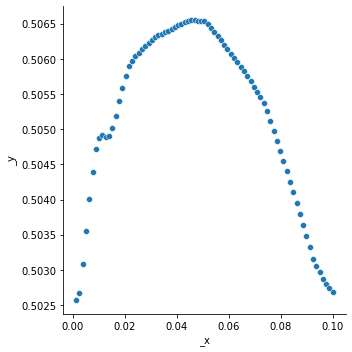

In [8]:
import seaborn as sns
sns.relplot(x=alpha,y=np.mean(scores,axis=1));

However, while ridge regression still uses all of the features, LASSO ignores four of them:

In [9]:
print("ridge coeffs:")
print(rr.coef_)
lass = Lasso(alpha=0.05)
lass.fit(X_tr,y_tr)
print("LASSO coeffs:")
print(lass.coef_)

ridge coeffs:
[ 35.59882969  -5.65413725 128.72386461  95.80592564  26.99211072
  13.94765865 -73.92991399  68.3705389  121.92677535  63.9783969 ]
LASSO coeffs:
[  -0.         -155.28275008  529.16520628  313.42663726 -132.50563763
   -0.         -165.17345325    0.          580.25912765   30.55647073]


We can use the magnitude of the LASSO coefficients to rank the relative importance of the predictive features. We have to make sure to take the absolute values of the coefficients, because we don't care about whether an effect is positive or negative, just its magnitude.

In [10]:
import numpy as np
# Get the permutation that sorts values in increasing order.
idx = np.argsort(np.abs(lass.coef_))  
idx = idx[::-1]    # reverse the order
idx

array([8, 2, 3, 6, 1, 4, 9, 7, 5, 0])

The last three features were dropped by LASSO:

In [11]:
zeroed = X.columns[idx[-3:]]
print(zeroed)

Index(['s4', 's2', 'age'], dtype='object')


Now we can drop these features from the dataset:

In [12]:
X_tr_reduced = X_tr.drop(zeroed,axis=1)
X_te_reduced = X_te.drop(zeroed,axis=1)
X_tr_reduced.head(5)

,sex,bmi,bp,s1,s3,s5,s6
70,-0.044642,-0.069797,-0.012556,-0.000193,0.070730,-0.062913,0.040343
37,-0.044642,0.011039,-0.057314,-0.024960,0.030232,0.017037,-0.005220
170,0.050680,-0.020218,-0.036656,-0.013953,0.059685,-0.096433,-0.017646
400,-0.044642,0.045529,0.090730,-0.018080,0.070730,-0.034524,-0.009362
286,-0.044642,-0.054707,-0.077971,-0.033216,0.140681,-0.019197,-0.005220


Returning to the original, unregularized fit, we find that hardly anything is lost by using the reduced feature set:

In [13]:
print("original linear model score:",lm.score(X_te,y_te))
lm.fit(X_tr_reduced,y_tr)
print("reduced linear model score:",lm.score(X_te_reduced,y_te))

original linear model score: 0.4399387660024645
reduced linear model score: 0.4388377188754573


<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_irlwjqis&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_zgo9xrkv" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>